<a href="https://colab.research.google.com/github/tfs4/image_pre-processing/blob/master/Graham's_preprocessing_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

SEED = 42
IMG_SIZE = 512
import warnings
warnings.filterwarnings("ignore")


In [4]:
df_test = pd.read_csv('/content/drive/MyDrive/idrid_teste/test.csv')

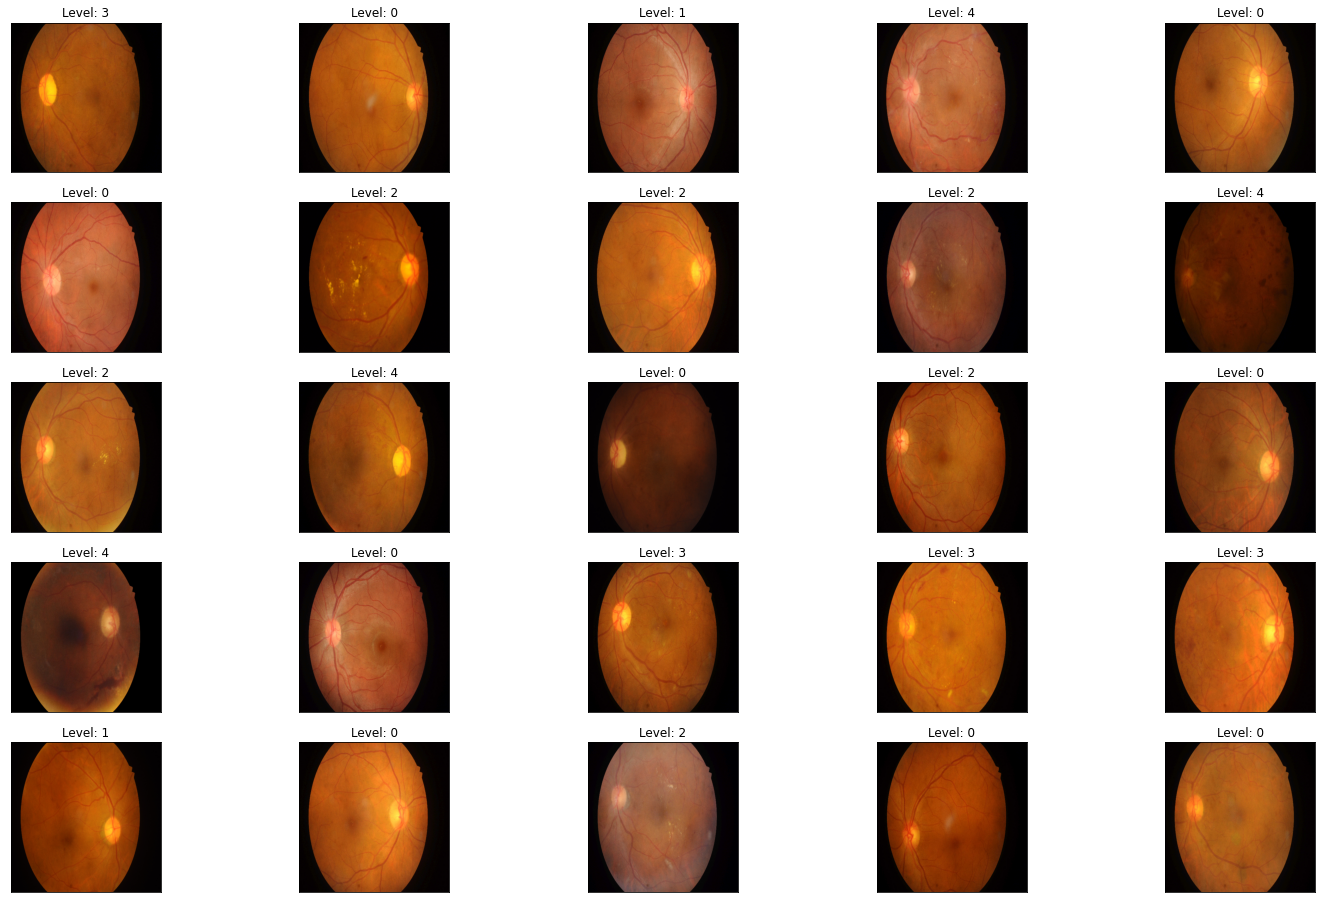

In [43]:
fig = plt.figure(figsize=(25, 16))
for i, (idx, row) in enumerate(df_test.sample(25, random_state=SEED).iterrows()):
    ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
    path=f"/content/drive/MyDrive/idrid_teste/test/{row['id_code']}.jpg"

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    plt.imshow(image, cmap='gray')
    ax.set_title('Level: %s' % (row['level']) )

We can try gray scale and feel understand better for some pictures, as color distraction is gone. For example, we can see more blood clearer in the upper part of pic(4,4), which has severity of level 4.

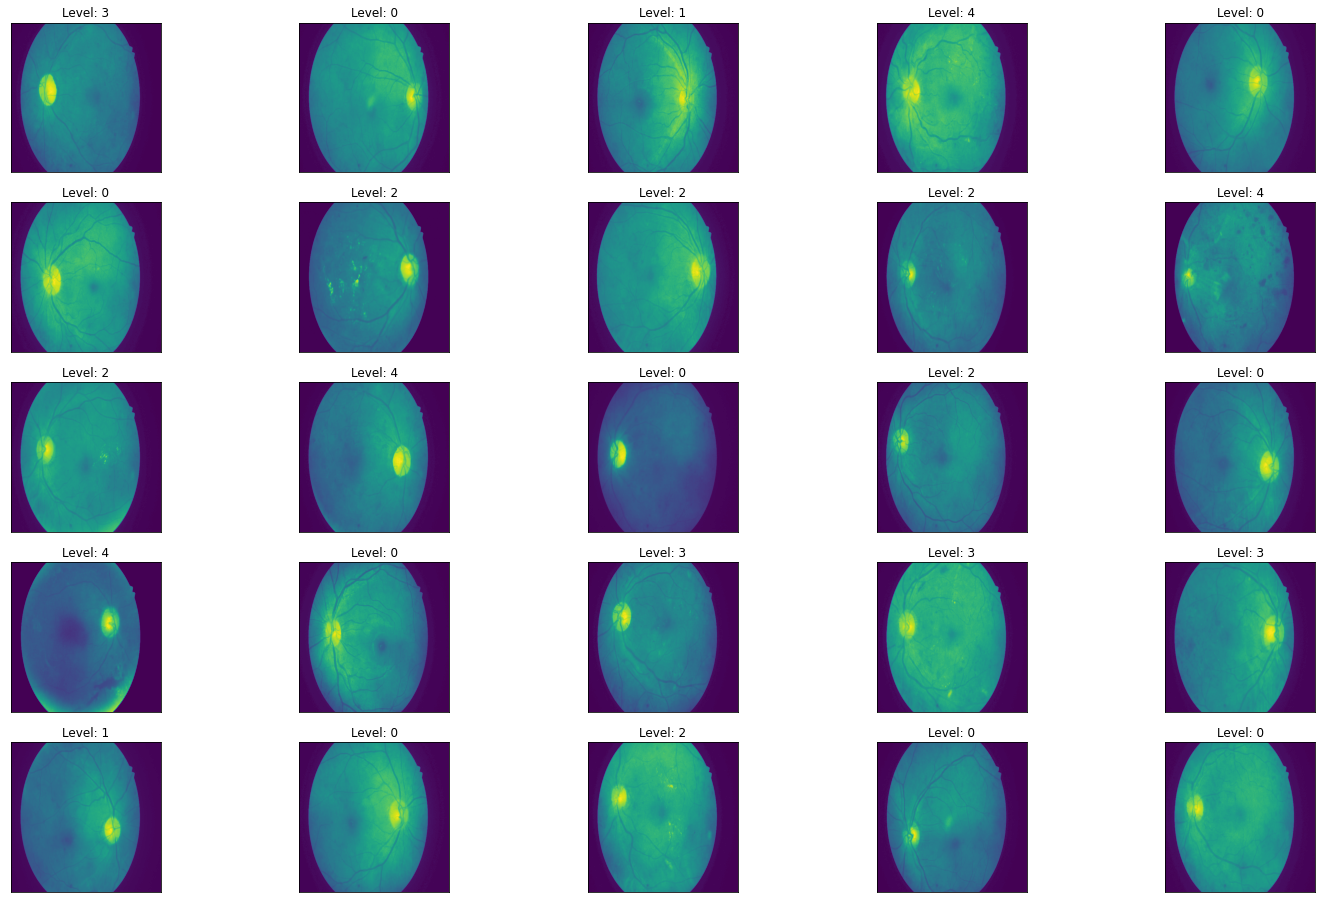

In [44]:

fig = plt.figure(figsize=(25, 16))
for i, (idx, row) in enumerate(df_test.sample(25, random_state=SEED).iterrows()):
    ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
    path=f"/content/drive/MyDrive/idrid_teste/test/{row['id_code']}.jpg"

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    plt.imshow(image)
    ax.set_title('Level: %s' % (row['level']) )
  

For severity level 4, I feel that two examples here are difficult to spot on, pic(4,1) and pic(4,4). As we try zooming to see the details (use real size image), we can see some abnormalities (cotton wool spots or hard exudates ?) in those eyes clearer (observe the lower-right part of the eye). Therefore, IMG_SIZE is definitely important for this problem. In the next section, we shall see better method than gray-scale conversion.

#Try Ben Graham's preprocessing method

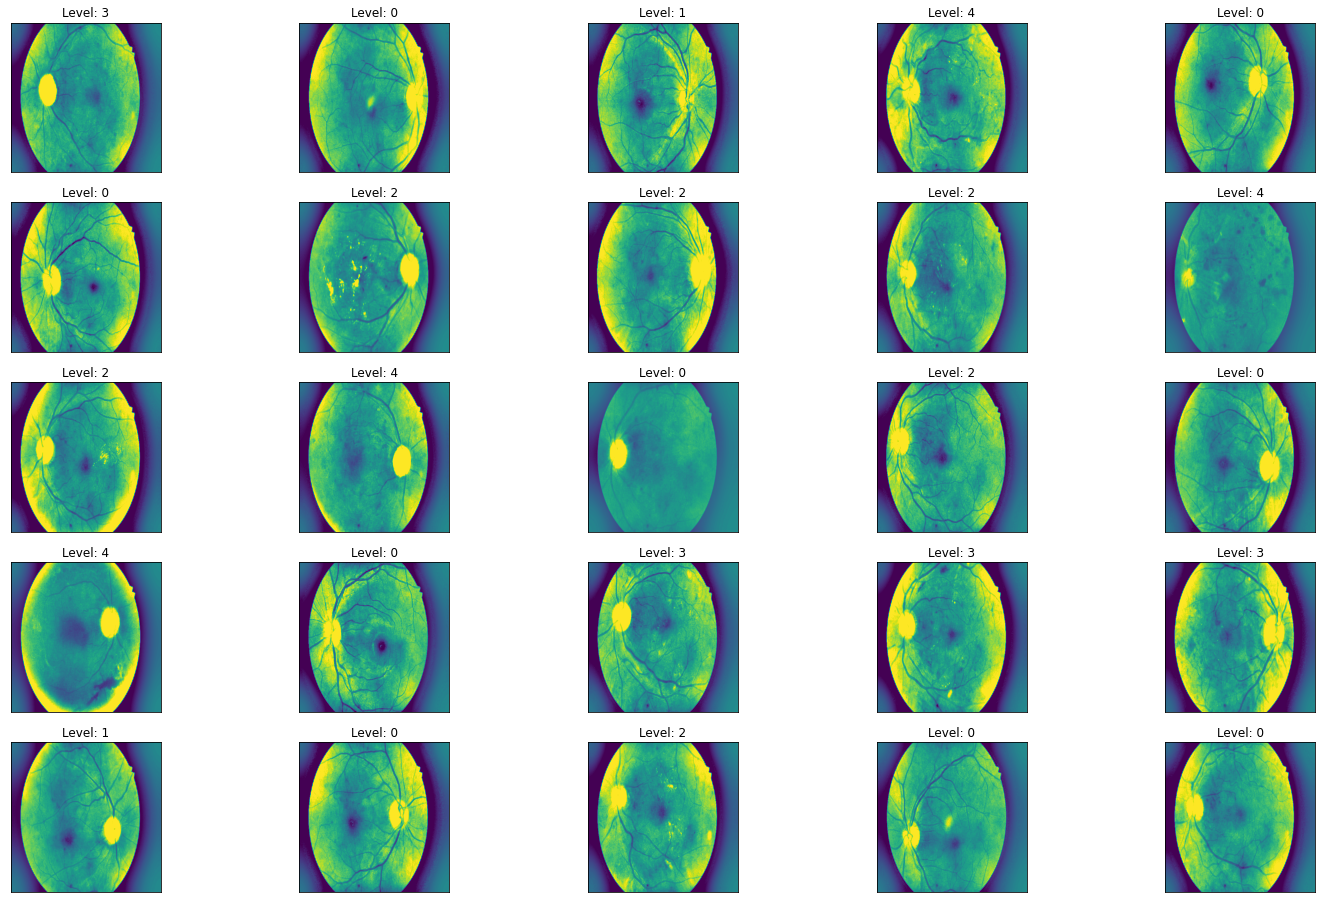

In [45]:
fig = plt.figure(figsize=(25, 16))
for i, (idx, row) in enumerate(df_test.sample(25, random_state=SEED).iterrows()):
    ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
    
    path=f"/content/drive/MyDrive/idrid_teste/test/{row['id_code']}.jpg"

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128)

    plt.imshow(image)
    ax.set_title('Level: %s' % (row['level']) )
  

In [49]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]


def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img


In [48]:
# OLD version of image color cropping, use crop_image_from_gray instead
# The above code work only for 1-channel. Here is my simple extension for 3-channels image
def crop_image(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        h,w,_=img.shape
#         print(h,w)
        img1=cv2.resize(crop_image1(img[:,:,0]),(w,h))
        img2=cv2.resize(crop_image1(img[:,:,1]),(w,h))
        img3=cv2.resize(crop_image1(img[:,:,2]),(w,h))
        
#         print(img1.shape,img2.shape,img3.shape)
        img[:,:,0]=img1
        img[:,:,1]=img2
        img[:,:,2]=img3
        return img

'''all of these do not work'''

def crop_image2(image,threshold=5):
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

def crop_image3(image):
    mask = image > 0

    # Coordinates of non-black pixels.
    coords = np.argwhere(mask)

    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get the contents of the bounding box.
    cropped = image[x0:x1, y0:y1]
    return cropped

def crop_image4(image):
    _,thresh = cv2.threshold(image,1,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    crop = image[y:y+h,x:x+w]
    return crop

In [53]:
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [50]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

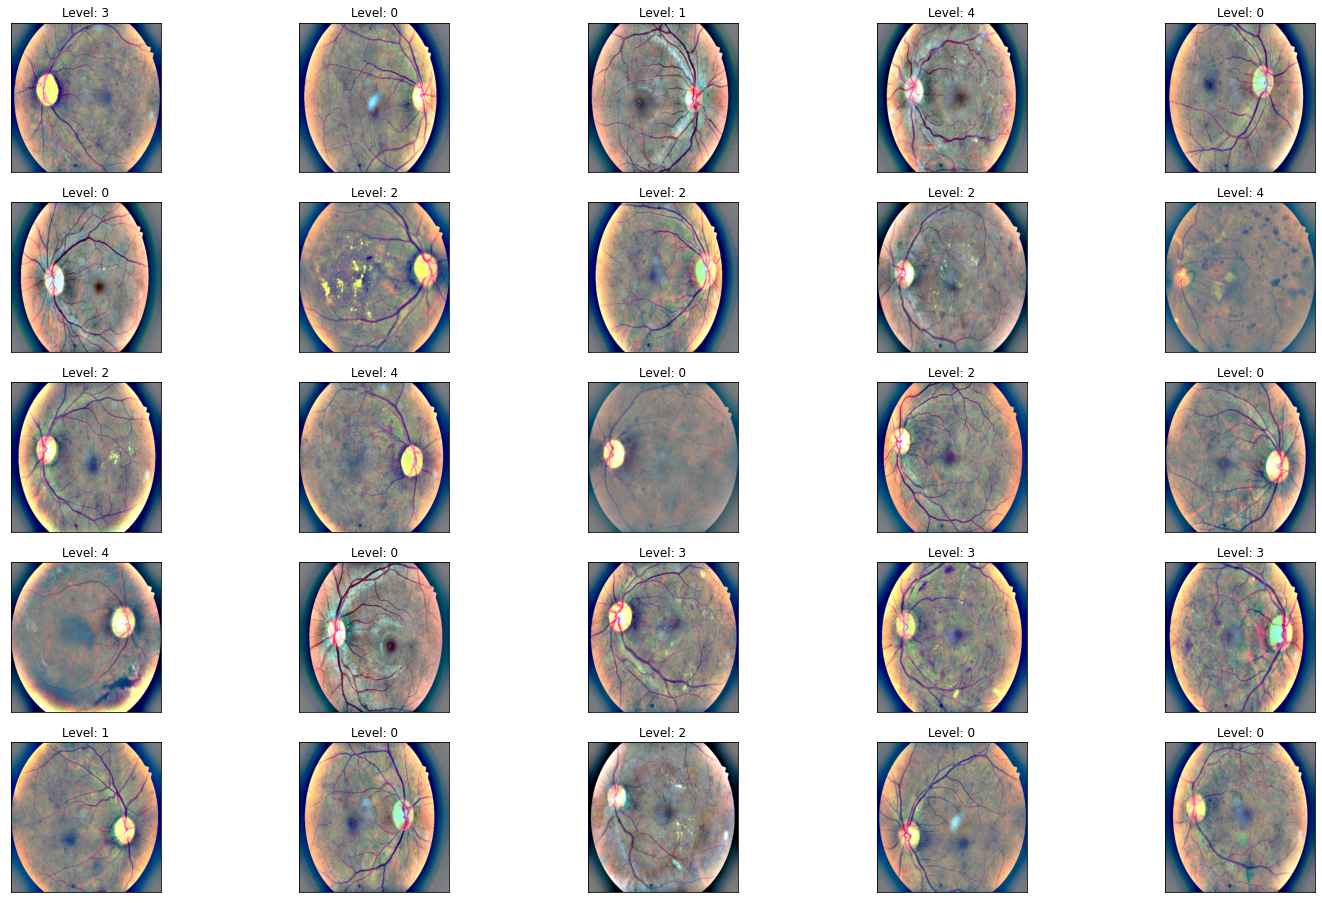

In [51]:
fig = plt.figure(figsize=(25, 16))
for i, (idx, row) in enumerate(df_test.sample(25, random_state=SEED).iterrows()):
    ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
    
    path=f"/content/drive/MyDrive/idrid_teste/test/{row['id_code']}.jpg"

    image = load_ben_color(path,sigmaX=30)

    plt.imshow(image)
    ax.set_title('Level: %s' % (row['level']) )

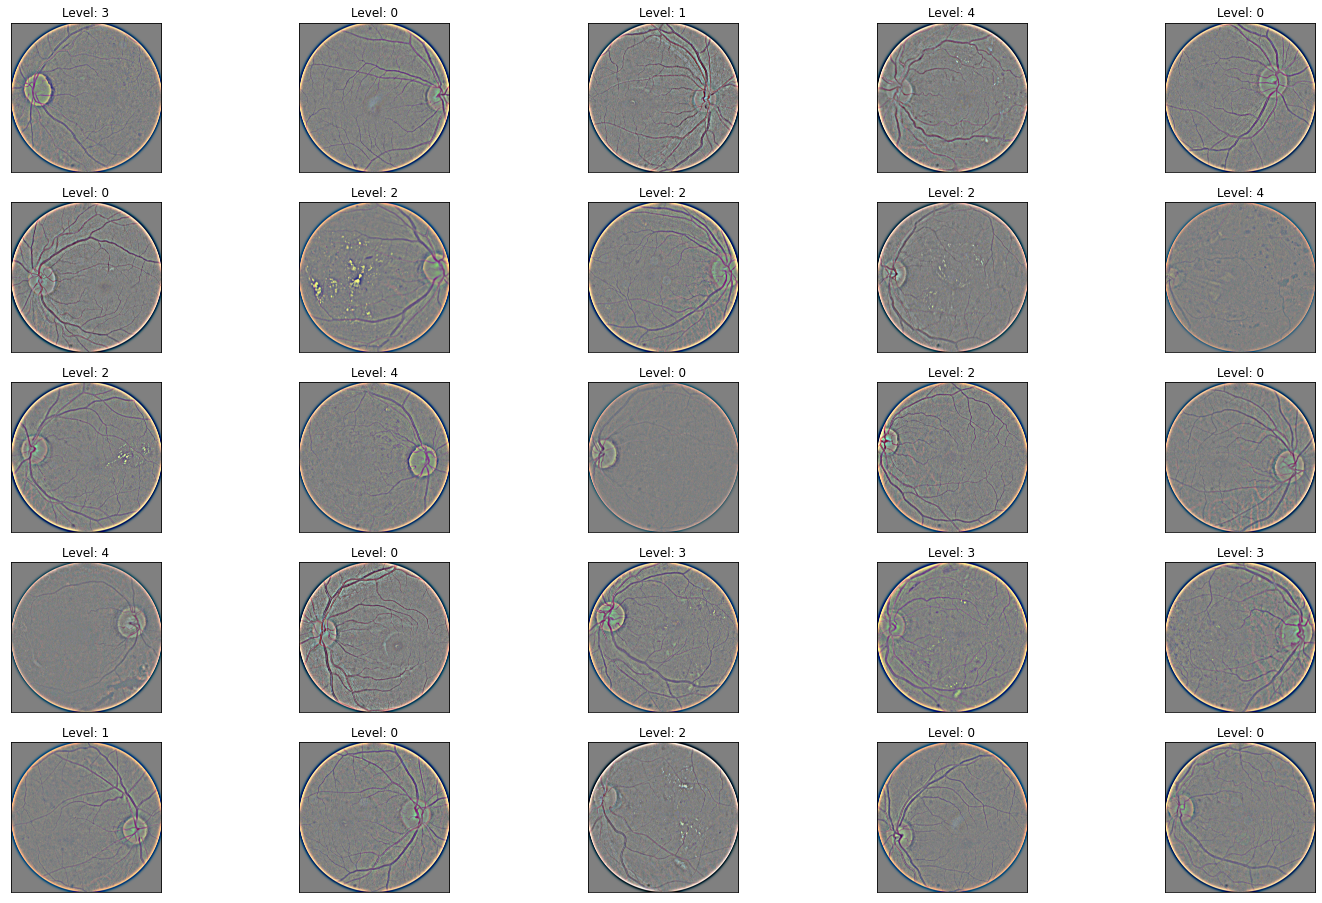

In [54]:

fig = plt.figure(figsize=(25, 16))
for i, (idx, row) in enumerate(df_test.sample(25, random_state=SEED).iterrows()):
    ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
    
    path=f"/content/drive/MyDrive/idrid_teste/test/{row['id_code']}.jpg"

    image = circle_crop(path,sigmaX=30)

    plt.imshow(image)
    ax.set_title('Level: %s' % (row['level']) )

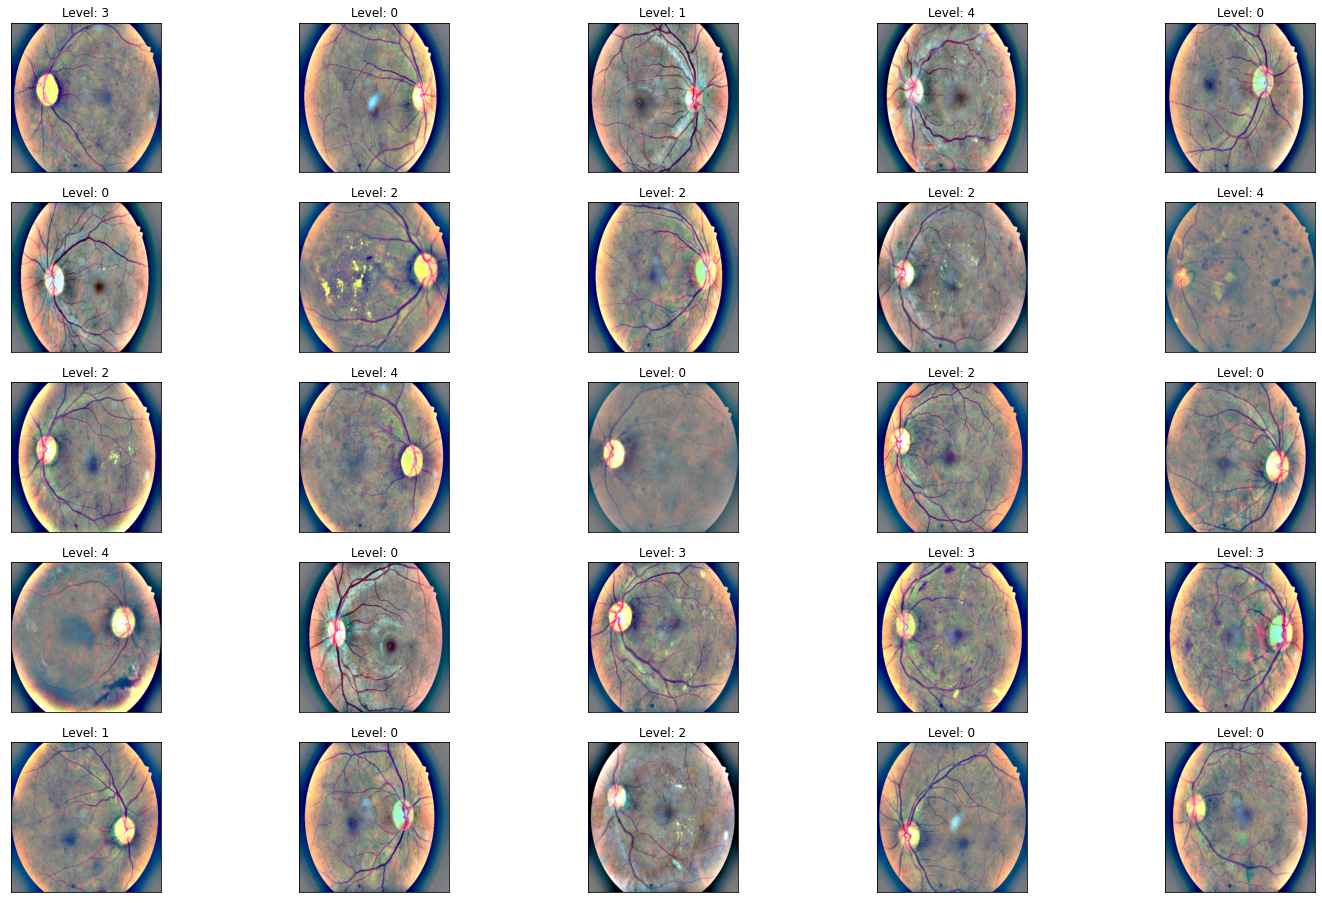

In [55]:

fig = plt.figure(figsize=(25, 16))
for i, (idx, row) in enumerate(df_test.sample(25, random_state=SEED).iterrows()):
    ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
    
    path=f"/content/drive/MyDrive/idrid_teste/test/{row['id_code']}.jpg"

    image = load_ben_color(path,sigmaX=30)

    plt.imshow(image)
    ax.set_title('Level: %s' % (row['level']) )